In [1]:
%%capture
import sys

# Añade el directorio principal al path de búsqueda para importar módulos desde esa ubicación
sys.path.insert(0, "..")

# Desactivar los warnings para evitar mensajes innecesarios durante la ejecución
import warnings

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from likelihood.tools import remove_collinearity
from likelihood.models.deep import GANRegressor

warnings.filterwarnings("ignore")
import tensorflow as tf
from tqdm import tqdm

import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10
plt.style.use("seaborn-v0_8")

In [2]:
data = datasets.fetch_california_housing()
# Convertir los datos a un DataFrame de pandas para facilitar la manipulación
df = pd.DataFrame(data=data.data, columns=data.feature_names)
train_stats = df.describe()
train_stats = train_stats.transpose()


# Normalizamos los datos - Ayuda a convergencia del algoritmo
def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]


df = norm(df)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.344709,0.982119,0.628544,-0.153754,-0.974405,-0.049595,1.052523,-1.327803
1,2.332181,-0.607004,0.327033,-0.263329,0.861418,-0.092510,1.043159,-1.322812
2,1.782656,1.856137,1.155592,-0.049015,-0.820757,-0.025842,1.038478,-1.332794
3,0.932945,1.856137,0.156962,-0.049832,-0.766010,-0.050328,1.038478,-1.337785
4,-0.012881,1.856137,0.344702,-0.032905,-0.759828,-0.085614,1.038478,-1.337785


In [3]:
def plot_results(pred, y):
    plt.figure(figsize=(5, 5))
    plt.plot(pred, y, ".")
    plt.plot([0, np.max(y)], [0, np.max(y)], "r--")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title("Predicciones vs Valores reales")
    plt.grid()
    plt.xlim(0, np.max(y))
    plt.ylim(0, np.max(y))
    plt.show()

+--------------------------------------------------+
| Metric          | Value                          |
+--------------------------------------------------+
| Epoch           | 19                             |
| Loss            | 35.86 / 41.64                  |
| Accuracy        | 93.75 / 93.75                  |
| Precision       | 89.44 / 89.44                  |
| Recall          | 99.22 / 99.22                  |
| F1 Score        | 94.07 / 94.07                  |
| Kappa           | 0.88 / 0.88                    |
+--------------------------------------------------+
645/645 [==============================] - 1s 1ms/step


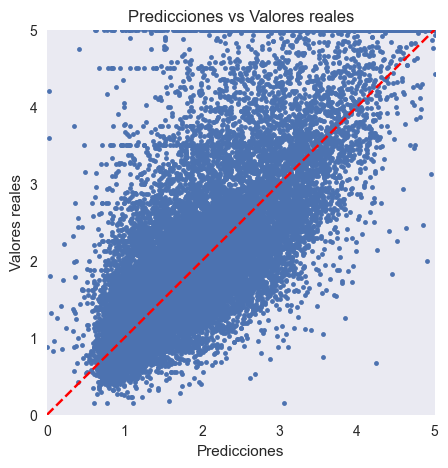

loss without fit generator: 28.64
645/645 [==============================] - 1s 1ms/step


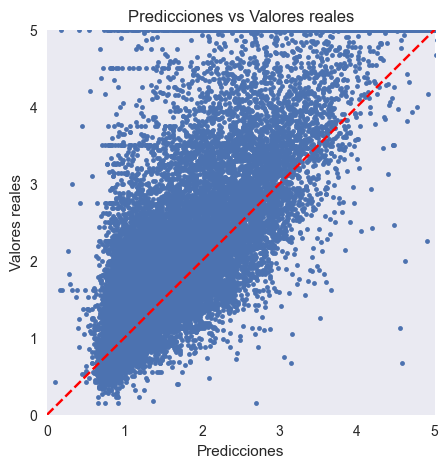

loss with fit generator: 26.06
Saving model to file...
Loading model from file...
Model loaded successfully
645/645 [==============================] - 1s 1ms/step
loss with fit generator: 26.06


In [4]:
batch_size = 1000
n_epochs = 20
depth = 2

df = remove_collinearity(df, threshold=0.85)
df["target"] = data.target  # Añadir la columna de etiquetas 'target'
# df = df.sample(frac=0.01)

y = df["target"].values

X = df.drop(columns="target").to_numpy()  # Extraer las características (sin la columna 'target')
X = np.asarray(X).astype(np.float32)  # Convertir X a tipo float32 para la entrada del modelo
y = np.asarray(y).astype(np.float32)  # Convertir y a tipo float32

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = X.shape[1:][0]
num_neurons = 64
output_shape = y.shape[1:] if len(y.shape) > 1 else 1
activation = "relu"

gan_regressor = GANRegressor(
    input_shape_parm=input_shape,
    output_shape_parm=output_shape,
    num_neurons=num_neurons,
    l2_reg=0.01,
)
gen_hist = gan_regressor.train_gan(X_train, y_train, batch_size=batch_size, n_epochs=n_epochs)

pred = gan_regressor.predict(X)
plot_results(pred, y)

loss = 100 * tf.math.reduce_mean(abs((y - pred) / y), keepdims=False)
print("loss without fit generator:", "{:.2f}".format(loss))

hist = gan_regressor.train_gen(X_train, y_train, batch_size=batch_size, n_epochs=n_epochs)
pred = gan_regressor.predict(X)

plot_results(pred, y)

loss = 100 * tf.math.reduce_mean(abs((y - pred) / y), keepdims=False)
print("loss with fit generator:", "{:.2f}".format(loss))

print("Saving model to file...")
gan_regressor.save("gan_model", save_format="tf")
print("Loading model from file...")
gan_regressor = tf.keras.models.load_model("gan_model")
print("Model loaded successfully")

pred = gan_regressor.predict(X)

loss = 100 * tf.math.reduce_mean(abs((y - pred) / y), keepdims=False)
print("loss with fit generator:", "{:.2f}".format(loss))

In [5]:
gen_hist.tail()

,epoch,loss
15,15,38.745934
16,16,38.270844
17,17,37.127098
18,18,36.913727
19,19,36.864773


In [6]:
hist.tail()

,loss,mean_absolute_percentage_error,val_loss,val_mean_absolute_percentage_error
12,40.680824,40.583797,38.383434,38.286316
13,40.332264,40.234585,38.261841,38.163807
14,40.395145,40.296463,38.136982,38.038193
15,40.526989,40.428078,38.254501,38.155209
16,40.397808,40.298065,38.411400,38.311661
